starting by importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
from GoogleNews import GoogleNews
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from os import path
from nltk.corpus import stopwords
from textblob import TextBlob
import statsmodels.api as sm
from scipy import stats
from nltk.probability import FreqDist
import nltk
nltk.download('stopwords')
from scipy.stats import shapiro
import warnings 
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sentiment analysis on Headlines from different media sources for Ireland, USA and UK

#### Data gathering

In order to extract headlines I'm going to use a library called GoogleNews
https://pypi.org/project/GoogleNews/

license here:
https://github.com/Iceloof/GoogleNews/blob/master/LICENSE

the .get_news() method from the GoogleNews library will return the first 100 results for article titles in google news for a specific search:

the argument selected are:

1. the search terms: "Housing Ireland" "Housing UK" "Housing USA"
2. a specific period 

My research is interested in identyfing trends over the previous 10 years so the function will loop through different periods of 6 months lenght and return the first 100 results for that specific period and search terms.

The data is then collected in a pandas dataframe.

In [2]:
#time dictionary for function

dict_time = {'06/01/2020' : '12/31/2020',
             '06/01/2021' : '12/31/2021',
             '06/01/2022' : '12/31/2022',
             '06/01/2023' : '12/31/2023',
             '06/01/2019' : '12/31/2019',
             '06/01/2018' : '12/31/2018',
             '06/01/2017' : '12/31/2017',
             '06/01/2016' : '12/31/2016',
             '06/01/2015' : '12/31/2015',
             '06/01/2014' : '12/31/2014',
             '01/01/2020' : '06/01/2020',
             '01/01/2021' : '06/01/2021',
             '01/01/2022' : '06/01/2022',
             '01/01/2023' : '06/01/2023',
             '01/01/2019' : '06/01/2019',
             '01/01/2018' : '06/01/2018',
             '01/01/2017' : '06/01/2017',
             '01/01/2016' : '06/01/2016',
             '01/01/2015' : '06/01/2015',
             '01/01/2014' : '06/01/2014'}

#creating function

def search_gn(s):
  df_final = pd.DataFrame()
  for x in dict_time:
    googlenews = GoogleNews(start=x,end=dict_time[x])
    googlenews.get_news(s)
    googlenews.enableException(True)
    result_FINAL = googlenews.result(sort=True)
    df_n = pd.DataFrame(result_FINAL)
    df_n['year'] = dict_time[x]
    df_n['year']= df_n['year'].str[-4:]
    df_final = df_final.append(df_n)
    
  return df_final

In [35]:
#applying function for 3 different search (UK, USA, Ireland)

Ireland = search_gn('Housing Ireland') 
Uk = search_gn('Housing UK') 
USA = search_gn('Housing USA') 

#function usually takes around 3/4 min to run 

Data cleaning and transformation on Article dataset:

1. Dropping duplicates
2. inserting Country label
3. creating one big final dataset
4. checking null values
5. eliminating null/useless attributes

Why dropping duplicates?

possible reasons of duplication:

1. as we are looping through different periods The same Article might be present in more than 1 loop if for example it has been republished more than 1 time in a year
2. because of Google Search engine optimization techniques an article might be picked up multiple times as considered relevant by Google news in different periods

In [36]:
#dropping ducplicates 

_Ireland = Ireland.drop_duplicates()
_Uk = Uk.drop_duplicates()
_USA = USA.drop_duplicates()

# Adding label to datasets

_Ireland['Country'] = 'Eire'
_Uk['Country'] = 'UK'
_USA['Country'] = 'USA'

In [ ]:
#concatenating into final dataset

frames = [_Ireland,_USA,_Uk]
Headlines = pd.concat(frames)
Headlines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4290 entries, 0 to 72
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     4290 non-null   object        
 1   desc      0 non-null      object        
 2   date      4290 non-null   object        
 3   datetime  4290 non-null   datetime64[ns]
 4   link      4290 non-null   object        
 5   img       4290 non-null   object        
 6   media     4290 non-null   object        
 7   site      0 non-null      object        
 8   year      4290 non-null   object        
 9   Country   4290 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 368.7+ KB


In [ ]:
Headlines.head()

,title,media,year,Country
0,"Pensioner, 78, with three weeks to find somewh...",Irish Mirror,2020,Eire
1,Countries Convene in Dublin for Ground-breakin...,Gov.ie,2020,Eire
2,Speech by Minister for Finance Michael McGrath...,Gov.ie,2020,Eire
3,Tiny homes Ireland: this company is bringing d...,image.ie,2020,Eire
4,Housing projects delayed over building cost in...,RTE.ie,2020,Eire


#### SAVING DATA INTO MYSQL DATABASE

Since the gathering operation might be time consuming I decided to store the resuls in a SQL database (and in a csv file as backup) so that there's no need to run the code everytime, especially helpful for debugging and testing reason

In [10]:
#saving as csv as backup
Headlines = Headlines[['title','media','year','Country']]
Headlines.to_csv('C:\\Users\\santi\\OneDrive\\Desktop\\CA\\backup.csv')

Connecting to MYSQL Server

In [5]:
import mysql.connector

host="localhost" # "127.0.0.1"
user="root" # root
password="Dublino1@" # root password

Creating the database in SQL by doing a bulk insert for the data we are interested in (title, media, year, country )

problem: apostrophe in the data might collide with the SQL synthax

example : INSERT INTO News (_title, _media, _year, _country) 
           VALUES ('2022', 'Ireland', 'Irish Examiner', ' O'<font color='red'>Hara said we should build more houses')</font>


by replacing " ' " with space we should be ready to go

In [13]:
#creating cursor
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    port = 3306
)
conn = db.cursor()

# first statements
conn.execute('DROP DATABASE IF EXISTS  Newspaper;')          #in case there's already a DB with the same name
conn.execute('CREATE DATABASE IF NOT EXISTS Newspaper;')
conn.execute('USE Newspaper;')
conn.execute('CREATE TABLE IF NOT EXISTS News (              _title VARCHAR(255),   _media VARCHAR(255),   _year INT,   _country VARCHAR(255)           );')

#removing " ' " from title and media

Headlines['title'] = Headlines['title'].str.replace("'", ' ')
Headlines['media'] = Headlines['media'].str.replace("'", ' ')

# iterating through dataset to get values to be inserted row by row 

lst = [(row['title'], row['media'],  row['year'], row['Country']) for i, row in Headlines.iterrows()]
print(lst)

#main query
query  = ' INSERT INTO News (_title, _media, _year, _country) VALUES (%s, %s,%s, %s); '

#execute many (thanks Sam)
conn.executemany(query,lst)

db.commit()

#exporting data from the SQL database
query_2 = "Select * from News;"
headlines = pd.read_sql(query_2,db)

#closing cursor for good measure
conn.close()
db.close()


[('Pensioner, 78, with three weeks to find somewhere to live tells how she feels like she  doesn t exist ', 'Irish Mirror', '2020', 'Eire'), ('Countries Convene in Dublin for Ground-breaking European ...', 'Gov.ie', '2020', 'Eire'), ('Speech by Minister for Finance Michael McGrath at the Irish Funds ...', 'Gov.ie', '2020', 'Eire'), ('Tiny homes Ireland: this company is bringing design-forward modular housing to Ireland', 'image.ie', '2020', 'Eire'), ('Housing projects delayed over building cost inflation', 'RTE.ie', '2020', 'Eire'), ('Fact-checking the Government s claims on social housing provision', 'The Irish Times', '2020', 'Eire'), ('Prem Group  actively looking  for properties to house staff', 'The Irish Times', '2020', 'Eire'), ('Only 1% of vacant site levies collected in 2021 – The Irish Times', 'The Irish Times', '2020', 'Eire'), ('Fionnán Sheahan: The 500 acres in Dublin city that are primed for housing but are ignored or just unseen', 'Independent.ie', '2020', 'Eire'), ('Sta

Now that the Data gathering, cleaning and transformation has been done we can start with the sentiment analysis

In [6]:
#extracting data from SQL

db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    port = 3306
)

conn = db.cursor()
conn.execute('USE Newspaper;')
query_2 = "Select * from News;"
headlines = pd.read_sql(query_2,db)

headlines.head()

,_title,_media,_year,_country
0,"Pensioner, 78, with three weeks to find somewh...",Irish Mirror,2020,Eire
1,Countries Convene in Dublin for Ground-breakin...,Gov.ie,2020,Eire
2,Speech by Minister for Finance Michael McGrath...,Gov.ie,2020,Eire
3,Tiny homes Ireland: this company is bringing d...,image.ie,2020,Eire
4,Housing projects delayed over building cost in...,RTE.ie,2020,Eire


In [7]:
#reset columns name
headlines = headlines.set_axis(['title', 'media', 'year', 'Country'], axis=1, inplace=False)

In [8]:
#checking nulls
headlines.isna().sum()

title      0
media      0
year       0
Country    0
dtype: int64

plotting number of articles by media

Text(0.5, 1.0, 'Number of articles by newspaper')

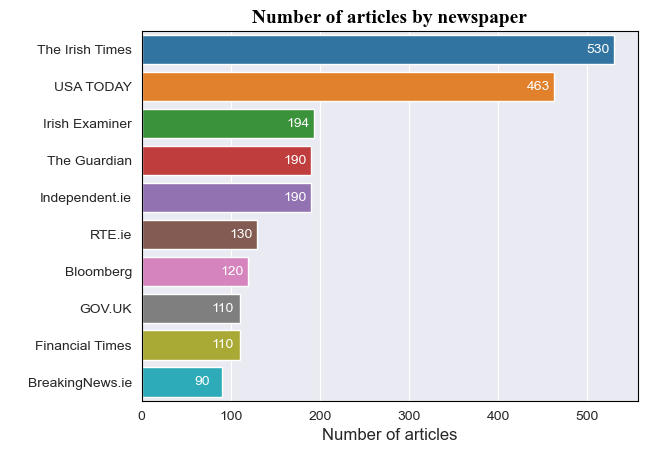

In [9]:
custom = {"axes.edgecolor": "black", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)
ax = sns.countplot(y=headlines["media"], order=headlines.media.value_counts().iloc[:10].index)
ax.bar_label(ax.containers[0], padding=-20, color='white', fontsize=10)
headlines["media"].unique()
ax.set_xlabel("Number of articles",fontsize=12)
ax.set_ylabel(" ")
ax.set_title("Number of articles by newspaper",fontsize=14,color= "black", weight='bold',fontname="Times New Roman")

Number of articles by country and year

Text(0.5, 1.0, 'Number of articles by year')

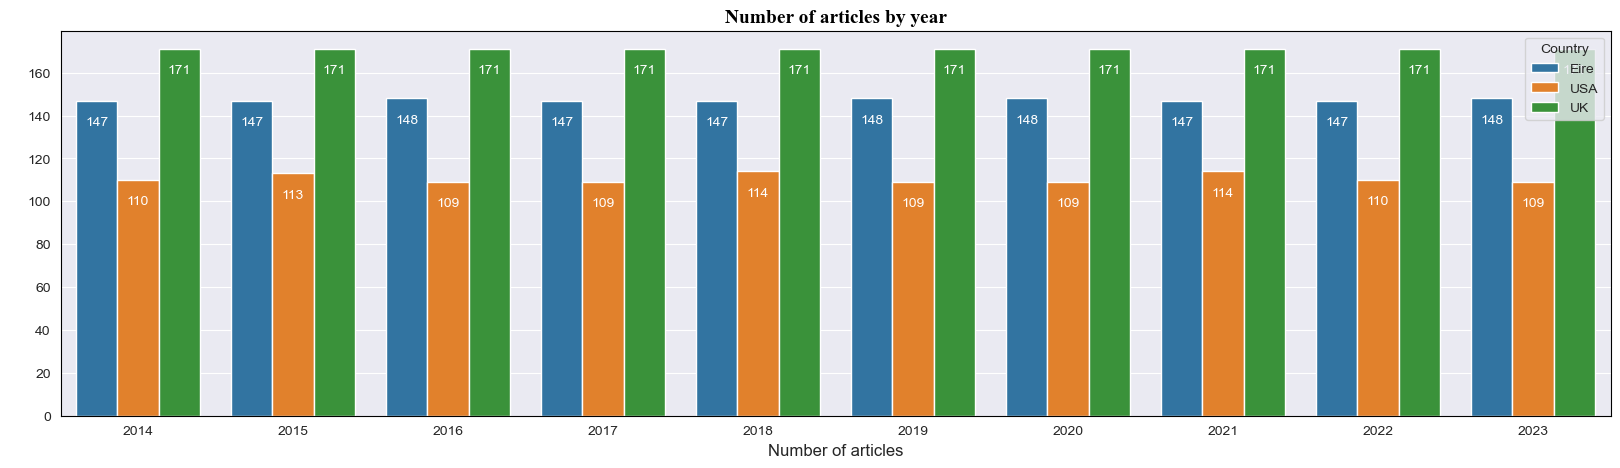

In [10]:
plt.rc('figure', figsize=(20, 5))
ax = sns.countplot(x=headlines["year"], hue=headlines['Country'])
for x in range(3):
    ax.bar_label(ax.containers[x], padding=-20, color='white', fontsize=10)
ax.set_xlabel("Number of articles",fontsize=12)
ax.set_ylabel(" ")
ax.set_title("Number of articles by year",fontsize=14,color= "black", weight='bold',fontname="Times New Roman")

Using text blob to assign a polarity score to each title

In [11]:
def sentiment_calc(text):
    try:
        return TextBlob(text).polarity  #there's also subjectivity if we want
    except:
        return None

headlines['polarity'] = headlines['title'].apply(sentiment_calc)

plotting polarity by country

<AxesSubplot:xlabel='Country', ylabel='polarity'>

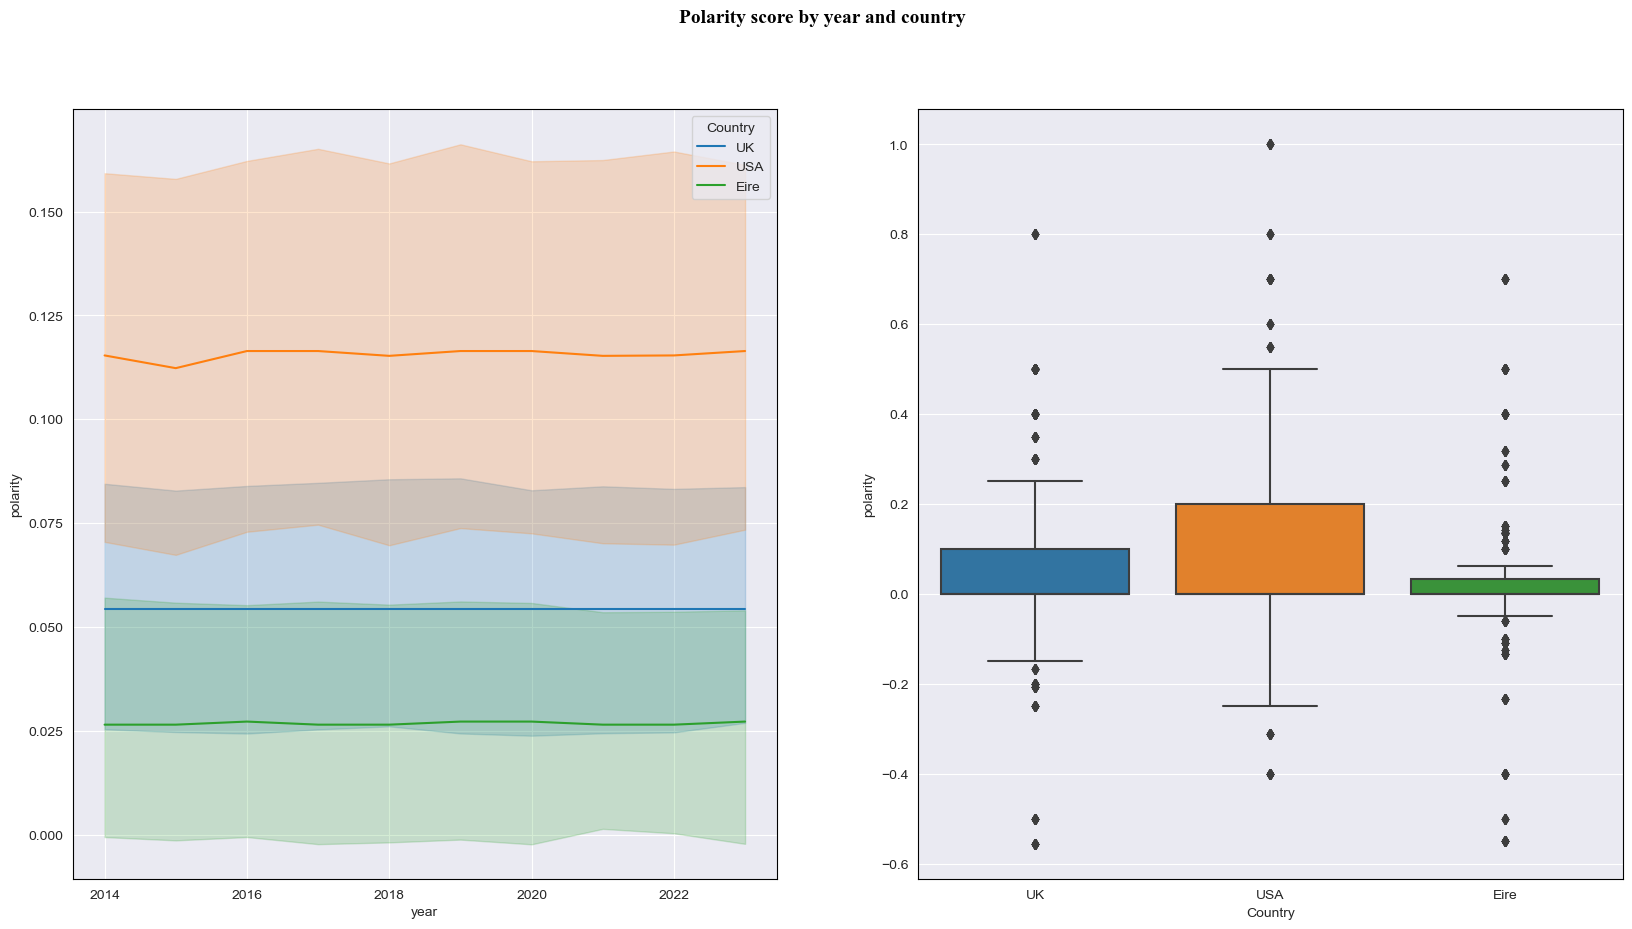

In [34]:
headlines = headlines.sort_values('year')
fig, ax = plt.subplots(1,2,figsize=(20, 10))
fig.suptitle('Polarity score by year and country',color= "black", weight='bold',fontname="Times New Roman",fontsize=14)
sns.lineplot(data = headlines,x='year',y='polarity',hue='Country',ax=ax[0])
sns.boxplot(y= 'polarity',data=headlines,x='Country',ax=ax[1])

In [13]:
for country in ['Eire','USA', 'UK']:
    var = headlines[headlines['Country']==country]
    var = var[['polarity']]
    print(f'Country: {country}')
    print(var.describe())
    print('-------------------')

Country: Eire
          polarity
count  1474.000000
mean      0.026753
std       0.175310
min      -0.550000
25%       0.000000
50%       0.000000
75%       0.033333
max       0.700000
-------------------
Country: USA
          polarity
count  1106.000000
mean      0.115552
std       0.244836
min      -0.400000
25%       0.000000
50%       0.000000
75%       0.200000
max       1.000000
-------------------
Country: UK
          polarity
count  1710.000000
mean      0.054317
std       0.194334
min      -0.557143
25%       0.000000
50%       0.000000
75%       0.100000
max       0.800000
-------------------


polarity scores seems to be around 0 for all three countries, In order to test if the scores are actually equivalent we can run a hypotesis test as follow:

H0 : population means are equal :     μ1 = μ2 = μ3 

H1 : population means are not equal 

First we check for nomality...

p value: 0.0
stat value: 0.8014999628067017
p value: 6.992479336980837e-43
stat value: 0.7438367605209351
p value: 1.5269793574720413e-32
stat value: 0.8321643471717834
p value: 1.4900426960705077e-40
stat value: 0.8144251108169556


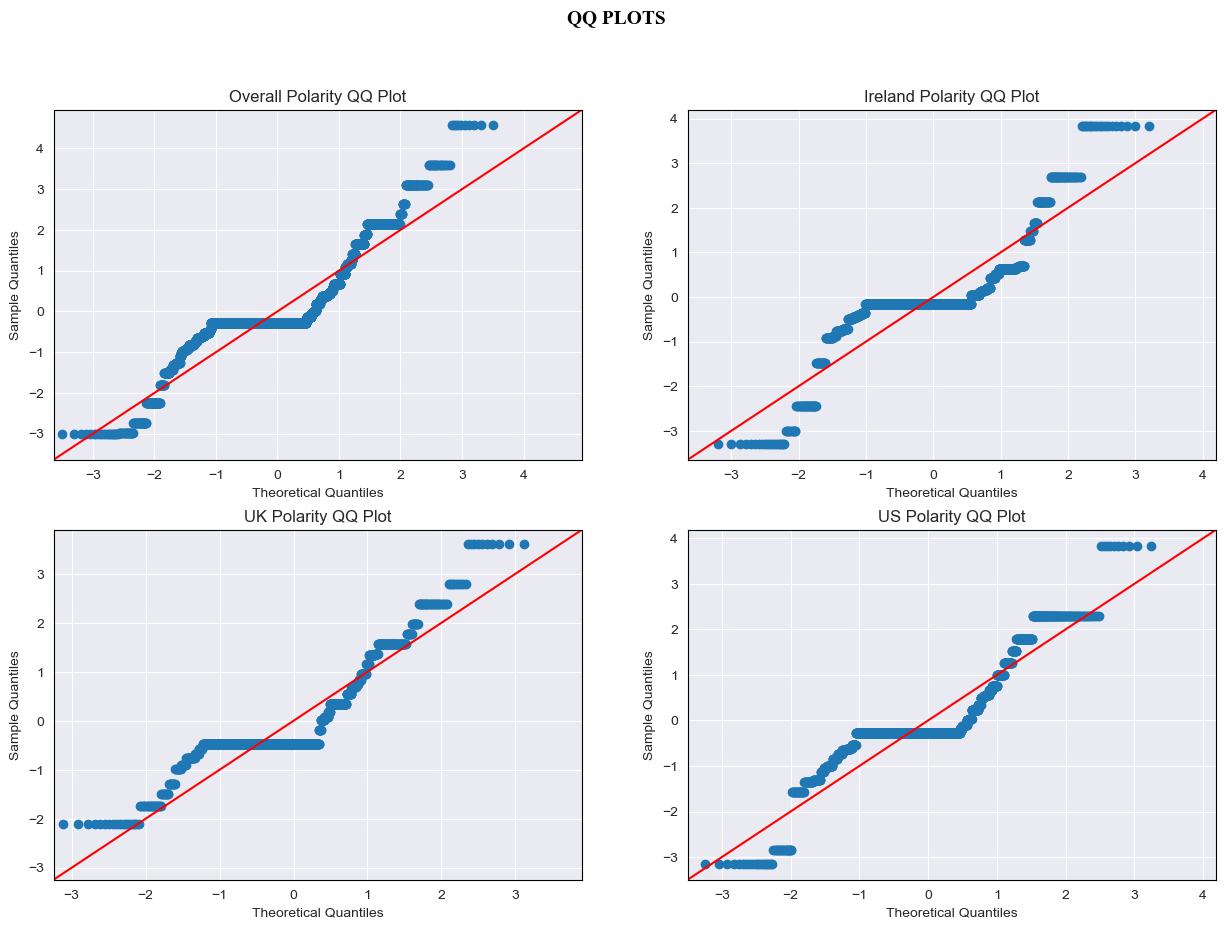

In [14]:
_E = headlines[headlines['Country']=='Eire']
_Uk = headlines[headlines['Country']=='USA'] 
_US = headlines[headlines['Country']=='UK']

fig, ax = plt.subplots(2,2,figsize=(15, 10))
fig.suptitle('QQ PLOTS',color= "black", weight='bold',fontname="Times New Roman",fontsize=14)
fig = sm.qqplot(headlines['polarity'], line='45' , fit = True,ax=ax[0,0])
ax[0, 0].set_title('Overall Polarity QQ Plot')
fig = sm.qqplot(_E['polarity'], line='45' ,fit = True, ax=ax[0,1])
ax[0, 1].set_title('Ireland Polarity QQ Plot')
fig = sm.qqplot(_Uk['polarity'], line='45' ,fit = True, ax=ax[1,0])
ax[1, 0].set_title('UK Polarity QQ Plot')
fig = sm.qqplot(_US['polarity'], line='45' ,fit = True, ax=ax[1,1])
ax[1, 1].set_title('US Polarity QQ Plot')

for x in [headlines['polarity'],_E['polarity'],_Uk['polarity'],_US['polarity']]:
    stat, p = shapiro(x)
    print('p value: ' + str(p))
    print('stat value: ' + str(stat))

Since the data is not normally distributed: non parametric tests will be run

since the test will be non parametric the hypotesis will get formulated again taking in consideration median instead of mean as follow:  

H0 : population medians are equal :     median 1 = median 2 = median 3 
 
H1 : population medians are not equal : at least one median is different from one of the other medians

the p value chosen is 0.05

In [15]:
stats.kruskal(_E['polarity'],_Uk['polarity'],_US['polarity'])

KruskalResult(statistic=55.446929892287265, pvalue=9.117004195427354e-13)

as per result we not accept H0:   Kruskal wallis test proved the 3 samples are not equal in terms of medians

what about comparing UK and Ireland? as the 2 countries are more similar between one another than with the US

as samples are not normal I will use another non parametric test: Mann–Whitney U as the samples are independent:

H0 : Ireland median = Uk median

H1 : Ireland median is not equal to Uk median

p value = 0.05

In [16]:
stats.mannwhitneyu(_E['polarity'],_Uk['polarity'])

MannwhitneyuResult(statistic=687928.0, pvalue=1.2220200938094188e-13)

result

we reject H0: the distributions underlying UK and Ireland polarity scores are not equal

## Topic understanding

In [17]:
#setting stopwords

import string
stopwords = set(stopwords.words("english"))
stopwords.add('housing')
stopwords.add('house')
stopwords.add('ireland')
stopwords.add('usa')
stopwords.add('uk')
stopwords.add('us')
stopwords.add(' ')
stopwords.add('')
stopwords.add('home')
stopwords.add('homes')
stopwords.add('irish')


#### tokenize

In [18]:
def tk(x):
    text = x.str.cat(sep=' ')
    tokens = nltk.word_tokenize(text)
    tokens = [''.join(char for char in item if char not in string.punctuation) for item in tokens]
    tokens = [x.lower() for x in tokens]
    filtered_token = []
    for w in tokens:
        if w not in stopwords:
          filtered_token.append(w)
    return filtered_token

eire = tk(_E['title'])
USA = tk(_US['title'])
uk = tk(_Uk['title'])

#### frequency plot

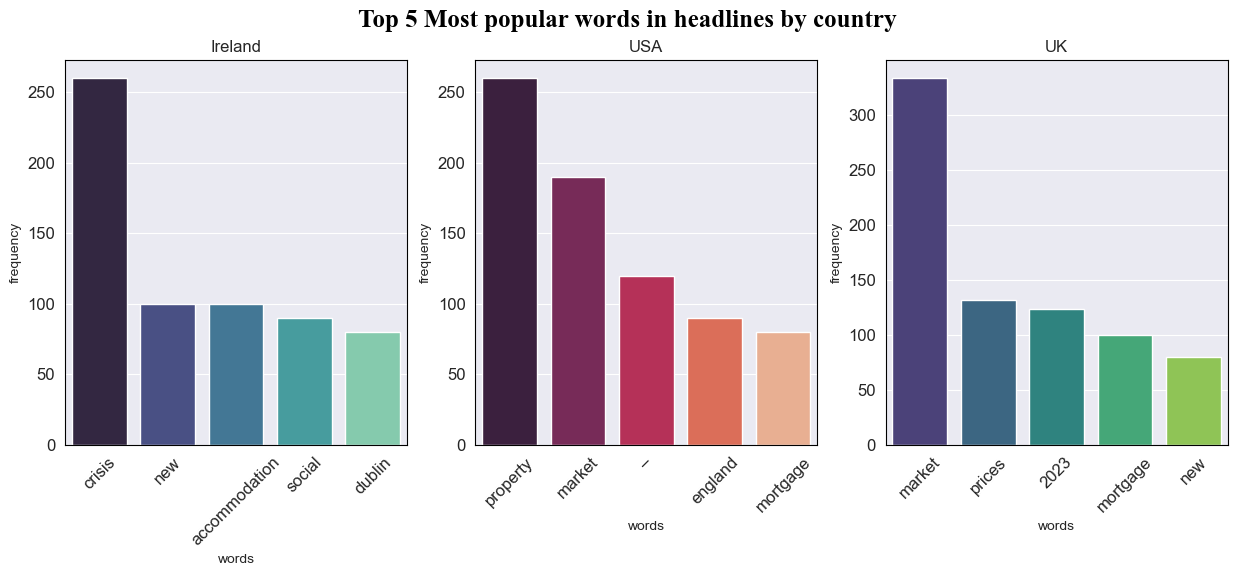

In [19]:
from collections import Counter
fig, ax = plt.subplots(1,3,figsize=(15, 5))
fig.suptitle('Top 5 Most popular words in headlines by country',fontsize=18,color= "black", weight='bold',fontname="Times New Roman")
a = Counter(eire)
a = pd.DataFrame.from_dict(a, orient='index').reset_index()
sns.barplot(y=0 ,x='index',data=a.nlargest(5, 0), ax=ax[0], palette= 'mako')
ax[0].set_title('Ireland')
ax[0].set(xlabel='words', ylabel='frequency')
ax[0].tick_params(axis='x',labelrotation=45, labelsize=12)
ax[0].tick_params(labelsize=12)
a = Counter(USA)
a = pd.DataFrame.from_dict(a, orient='index').reset_index()
sns.barplot(y=0,x='index',data=a.nlargest(5, 0),ax=ax[1], palette= 'rocket')
ax[1].set_title('USA')
ax[1].set(xlabel='words', ylabel='frequency')
ax[1].tick_params(axis='x',labelrotation=45,labelsize=12)
ax[1].tick_params(labelsize=12)
a = Counter(uk)
a = pd.DataFrame.from_dict(a, orient='index').reset_index()
sns.barplot(y=0,x='index',data=a.nlargest(5, 0), ax=ax[2], palette= 'viridis')
ax[2].set_title('UK')
ax[2].set(xlabel='words', ylabel='frequency')
ax[2].tick_params(axis='x',labelrotation=45,labelsize=12)
ax[2].tick_params(labelsize=12)


#### plotting polarity scores

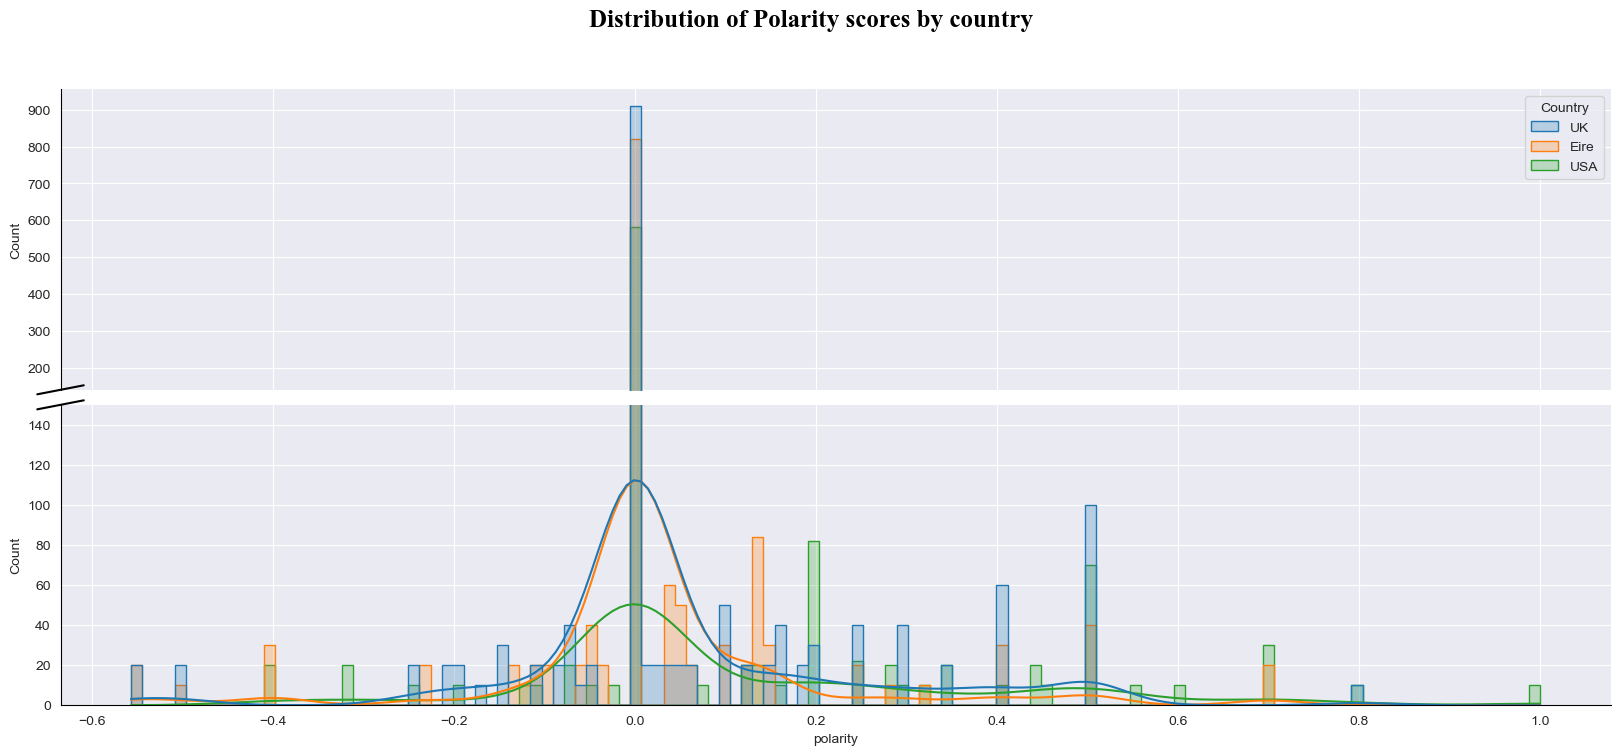

In [20]:
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.05},figsize=(20, 8))
f.suptitle('Distribution of Polarity scores by country',fontsize=18,color= "black", weight='bold',fontname="Times New Roman")
sns.histplot(x= 'polarity',data=headlines, hue='Country',kde=True , ax=ax_top, element="step")
sns.histplot(x= 'polarity',data=headlines, hue='Country',kde=True , ax=ax_bottom, element="step")
ax_top.set_ylim(bottom=140) 
ax_bottom.set_ylim(0,150)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

ax = ax_top
d = .015 
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs) 

ax_bottom.legend_.remove()
plt.show()

#### Topic modelling using LDA

In [22]:
Ire = headlines[['title','media','Country','year']]
Ire = Ire[Ire['Country']=='Eire']

In [23]:
Ire.head()

,title,media,Country,year
974,"Housing officials confident that 30,000 home...",Irish Examiner,Eire,2014
975,Luxembourg landlord fights eviction from Dubli...,The Irish Times,Eire,2014
976,How many new homes will be constructed in Irel...,The Irish Times,Eire,2014
977,Reality of shameful Irish housing crisis was a...,Buzz.ie,Eire,2014
978,Bill for housing Ukrainian refugees in Ireland...,Irish Mirror,Eire,2014


function for checking if text is a word 

In [24]:
def is_letter_only(word):
    for char in word:
        if not char.isalpha():
            return False
    return True

lemmatization and data cleaning on news titles

In [25]:
import nltk
nltk.download('omw-1.4')
  
data_cleaned = []
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

for doc in Ire['title']:
    doc = doc.lower()
    doc_cleaned = ' '.join(lemmatizer.lemmatize(word) for word in doc.split() if is_letter_only(word) and word not in stopwords)
    data_cleaned.append(doc_cleaned)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:
data_cleaned

['official confident delivered',
 'luxembourg landlord fight eviction dublin rent',
 'many new constructed',
 'reality shameful crisis zone biden visit',
 'bill ukrainian refugee hit billion within week',
 'government pay heavy price',
 'poultry confinement order lifted',
 'community benefit increased value zoned land new',
 'call curb social part kerry',
 'state purchase tenant eligible social',
 'school staffing watching talented young colleague leave',
 'australian meet young sydney facing',
 'new asylum seeker without state accommodation',
 'mary policy right',
 'five house buy right tourist city big town',
 'cost drive unsustainable pay demand jet leasing',
 'eu veto sends plan disarray',
 'crisis adversely affecting life say tui',
 'mary lou mcdonald reject idea sinn féin policy prompting',
 'released land development',
 'time view coalition need mind',
 'state ordered modular refugee without enough site',
 'crisis cusp changing claim taoiseach',
 'limerick people asked share opi

count vectorizer with max df = 0.5 and no limit in number of features as dataset is small enough to be processed in full

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Declare and create an array (count_vector) by calling a method CountVectorizer()
count_vector = CountVectorizer(stop_words = "english", max_features = None, max_df = 0.5, min_df = 2)
data = count_vector.fit_transform(data_cleaned)

#### LDA modelling

In [28]:
from sklearn.decomposition import LatentDirichletAllocation

# Declare and initialise a variable t
t = 5

# Declare and initialise an object 'lda' by calling a method LatentDirichletAllocation()
lda = LatentDirichletAllocation(n_components = t, learning_method = 'batch', random_state = 42)

# Train the model
lda.fit(data)

# Print all lda components
print(lda.components_)

# Get all feature names
terms = count_vector.get_feature_names_out()

[[10.16559032  0.2000046   0.20000668 ... 20.20379777  0.20000416
  10.19998421]
 [30.13026654  0.20000275 20.19997347 ...  0.20000665  0.200003
   0.20000243]
 [20.22682735 20.19998352  0.20000688 ...  0.20001096  0.20000395
   0.20000415]
 [10.15660556  0.20000385  0.20000551 ... 20.19617184  0.2000036
   0.20000348]
 [30.32071022  0.20000528  0.20000747 ...  0.20001278 10.19998528
   0.20000573]]


#### printing discovered topics

In [29]:
for topic_idx, topic in enumerate(lda.components_):
        print("Topic {}:" .format(topic_idx))
        print(" ".join([terms[i] for i in topic.argsort()[-10:]]))

Topic 0:
young modular issue south minister city live state confident michael
Topic 1:
impact site need week people time say ukrainian refugee crisis
Topic 2:
country pay development government land inflation dublin project cost social
Topic 3:
tax opinion rent tenant set needed year crisis homeless month
Topic 4:
benefit construction town big way hit state accommodation shortage new


#### Creating word cloud from feature names in count vectorizer

In [30]:
corpus = Ire['title']
vectorizer = CountVectorizer(
                             stop_words = 'english')
X = vectorizer.fit_transform(corpus)

# Display the feature names in sorted order
topic = vectorizer.get_feature_names_out()
_topic = [lemmatizer.lemmatize(word) for word in topic if is_letter_only(word)]
print(_topic)

['accommodation', 'acquiring', 'acre', 'act', 'action', 'actively', 'admits', 'adult', 'adversely', 'affecting', 'affordable', 'african', 'agency', 'allowed', 'amid', 'anger', 'animal', 'appeal', 'approach', 'asked', 'asylum', 'australian', 'bad', 'ban', 'bang', 'benefit', 'berlin', 'bid', 'biden', 'big', 'biggest', 'billion', 'black', 'body', 'boom', 'brain', 'breaking', 'brien', 'bringing', 'broken', 'bubble', 'builder', 'building', 'build', 'built', 'burst', 'buy', 'cabin', 'cabinet', 'call', 'capitalism', 'carry', 'cater', 'caught', 'centre', 'ceo', 'changed', 'changing', 'charity', 'cheap', 'checking', 'child', 'choked', 'city', 'city', 'claim', 'clause', 'cliff', 'closure', 'coalition', 'colleague', 'collected', 'comedian', 'communal', 'community', 'companionship', 'company', 'competitiveness', 'complained', 'complete', 'completion', 'concern', 'confident', 'confinement', 'consider', 'constructed', 'construction', 'contacting', 'convene', 'converted', 'cork', 'cost', 'cost', 'cou

plotting Word cloud 

accommodation acquiring acre act action actively admits adult adversely affecting affordable african agency allowed amid anger animal appeal approach asked asylum australian bad ban bang benefit berlin bid biden big biggest billion black body boom brain breaking brien bringing broken bubble builder building build built burst buy cabin cabinet call capitalism carry cater caught centre ceo changed changing charity cheap checking child choked city city claim clause cliff closure coalition colleague collected comedian communal community companionship company competitiveness complained complete completion concern confident confinement consider constructed construction contacting convene converted cork cost cost council country country court coveney crisis crisis criticism curb cusp cut damp darragh deal debate decade decide delayed delivered demand demand denied design despite deterring developer development development dexcom difficult disarray discus doe doesn dog doubt dream drive droghe

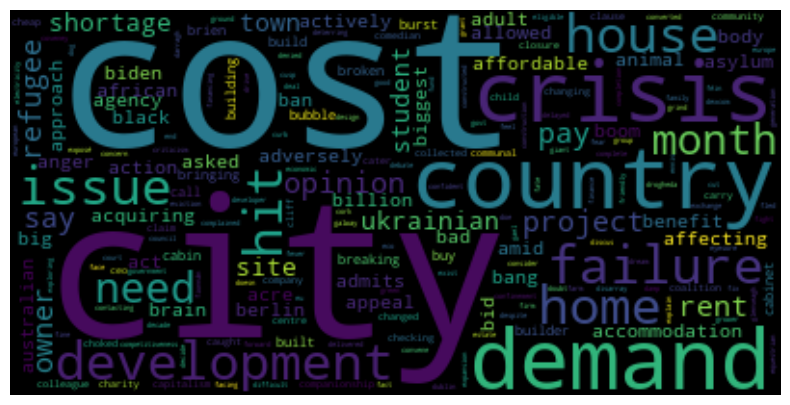

In [31]:
from wordcloud import WordCloud
text = ' '.join(_topic)

print(text)
# define some text to generate word cloud from

# create a word cloud object with default settings
wordcloud = WordCloud().generate(text)

# display the generated word cloud
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()